In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import seaborn as sns

## Preparation of Data

In [26]:
def preparing_data(w_true, b=0,n_samples=25, feature_range=(-3, 3),random_seed=42):
    """
    Generate synthetic data for binary classification with labels in {-1, +1}.
    
    Parameters: 
        w_true (ndarray): True weight vector used for computing probabilities.
        b (float): Bias term for the decision function.
        n_samples (int): Number of samples to generate.
        feature_range (tuple): Range for the feature values.
        random_seed (int): Seed for random number generation.
    Returns:
        X (ndarray): Feature matrix of shape (n_samples, 2).
        y (ndarray): Binary labels of shape (n_samples, 1), in the range {-1, +1}.
        probabilities (ndarray): Probabilities of the positive class for each sample.
    
    Example:
        X, y, probabilities = preparing_data(seed=42, n_samples=25, feature_range=(-3, 3), w_true=np.array([1, 2]), b=0)
    """
    rng = np.random.default_rng(seed=random_seed)
    
    # Generate random feature samples
    X = rng.uniform(low=feature_range[0], high=feature_range[1], size=(n_samples, 2))
    
    # Compute probabilities using the sigmoid function
    z = (X @ w_true.T + b).reshape(-1, 1)
    sigmoid = lambda z: 1 / (1 + np.exp(-z))
    probabilities = sigmoid(z)
    
    # Generate binary labels based on probabilities
    y = 2 * (rng.uniform(0, 1, size=(n_samples, 1)) <= probabilities) - 1
    
    return X, y, probabilities
X,y,probabilities=preparing_data(w_true=np.array([1, 2]),b=0,n_samples=25, feature_range=(-3, 3),random_seed=42)


In [ ]:

def hinge_losses(X, y, w, b):
    """
    Function: Compute hinge loss on the data X with respect to labels y=+1 and y=-1.

    Parameters:
        X(numpy array): Input feature matrix of shape (no.samples, no.features)
        y(numpy array): Target labels mapped to +1 and -1, shape (no.samples, 1)
        w(numpy array): Weight vector of shape (1, no.features)
        b(numpy array): Bias term,scalar or (no.samples, 1) if exists
    Returns:
        loss(numpy array): Returns hinge loss vectors of the shape (1, no.samples) with each corrsonding to hingeloss of datapoint in X.
                           Loss for misclassified points increases linearly as the 
    """
    w = w.reshape(1, -1)  # Ensure w is reshaped to (1, d)
    z = (X @ w.T + b)  # Compute decision function
    return np.maximum(0, 1 - y * z)  # loss for missclassified points increases linearly as z increases negitively . Whereas, loss for correctly classified is 0.

def regularized_loss(w, X, y, b=None, reg_param=0.01):
    """
    Function: Compute the regularized loss, which includes hinge loss and a regularization term.

    Parameters:
        X(numpy array): Input feature matrix of shape (no.samples, no.features)
        y(numpy array): Target labels mapped to +1 and -1, shape (no.samples, 1)
        w(numpy array): Weight vector of shape (1, no.features)
        b(float): Bias term  if exists

        Returns:
        regularizedloss(float): Returns regularized loss
    """
    w = w.reshape(1, -1)  # Ensure w is reshaped to (1, d)
    hinge_loss_vals = hinge_losses(X, y, w, b)  # Compute hinge loss
    reg_term = reg_param * np.linalg.norm(w)**2  # Regularization term
    return np.mean(hinge_loss_vals) + reg_term  # Total loss


def simplex_optimization(X,y,b=0,opt_func=regularized_loss,reg_param=0.001):
    """
    Function: Optimization of a regualarized loss function using Nelder-Mead Simplex function.

    Parameters:
        X(numpy array): Input feature matrix of shape (no.samples, no.features)
        y(numpy array): Target labels mapped to +1 and -1, shape (no.samples,1)
        b(float): Bias intercept for the linear model
        opt_func: A regularized function is optimzed with additional parameters b and regulation parameters
    Returns:
        w_optimized: tuple(1,no.features): Returns optimal weight vector w 
    """
    
    # Initialize weights of the shape (1,d)
    w_initial = np.zeros((1, X.shape[1]))  


    # Optimize using scipy.optimize.fmin using Nelder-Mead simplex algorithm
    w_optimized= optimize.fmin( func=opt_func,
                                x0=w_initial.flatten(),  # Flatten weights for optimization
                                args=(X, y, b, reg_param))
    return w_optimized.reshape(1,-1)

w_optimized=simplex_optimization(X,y,b=0,opt_func=regularized_loss,reg_param=0.001)



Optimization terminated successfully.
         Current function value: 0.203936
         Iterations: 47
         Function evaluations: 88


## Optimization of weights

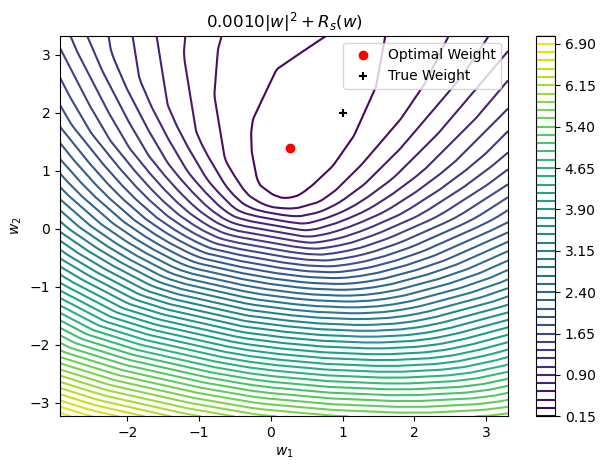

In [29]:
def contour_plot_visualization(X, y, w_optimized, 
                               regularized_loss, w_true,
                               reg_param=0.001, step=0.03,save_fig=True):
    """
    Plot the regularized loss landscape and visualize the optimal and true weights.

    Parameters:
        X (ndarray): Feature matrix (n_samples, n_features).
        y (ndarray): Target labels (n_samples,).
        w_optimized (ndarray): Optimized weight vector.
        w_true (ndarray): True weight vector.
        regularized_loss (function): Function to compute regularized loss.
        reg_param (float): Regularization parameter.
        step (float): Step size for creating the meshgrid.
        save_fig(bool): Saves the the boundary plot in the current folder.


    Returns:
        Displays and saves optimization of weights plot 
    """
    # Define ranges for the meshgrid
    x_min = min(X[:, 0]) - 0.5
    x_max = max(X[:, 0]) + 0.5
    y_min = min(X[:, 1]) - 0.5
    y_max = max(X[:, 1]) + 0.5

    # Create meshgrid
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, step),
        np.arange(y_min, y_max, step)
    )

    # Flatten meshgrid into points for evaluation
    mesh_points = np.c_[xx.ravel(), yy.ravel()]

    # Compute regularized losses for each point in the meshgrid
    reg_losses = [
        regularized_loss(
            w=point.reshape(1, -1),  # Reshape each point as a weight vector
            X=X,
            y=y,
            b=0,
            reg_param=reg_param
        )
        for point in mesh_points
    ]

    # Reshape reg_losses to match the meshgrid
    reg_losses = np.array(reg_losses).reshape(xx.shape)

    # Plot the contour
    fig, ax = plt.subplots()

    CS = ax.contour(xx, yy, reg_losses, 60)

    # Plot optimized and true weights
    ax.scatter(w_optimized[0][0], w_optimized[0][1], c="r", label="Optimal Weight")
    ax.scatter(w_true[0], w_true[1], marker="+", c="k", label="True Weight")

    ax.set_title(f"$ {reg_param:.4f} |w|^2 + R_s(w)$")
    ax.set_xlabel('$w_1$')
    ax.set_ylabel('$w_2$')
    plt.legend()
    fig.colorbar(CS)
    plt.tight_layout()
    if save_fig:
        fig.savefig("SVM_contour_plot")
    plt.show()
contour_plot_visualization(X, y, w_optimized,  regularized_loss,w_true=np.array([1,2]), reg_param=0.001, step=0.03)

## Decison boundary plot

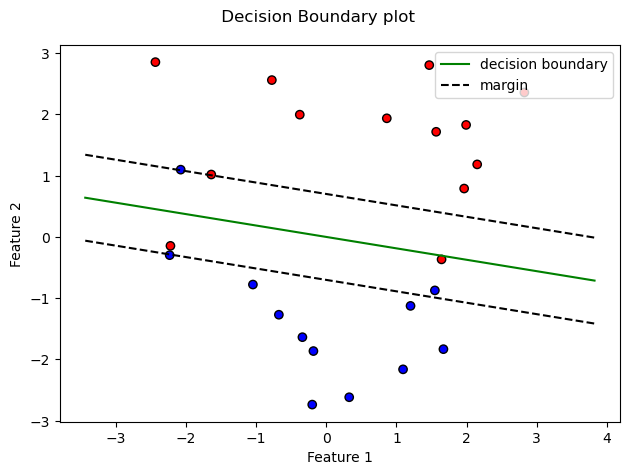

In [ ]:
def plot_svm_decison_boundary(X,w_optimized,b=0,save_fig=True):
    """
    Plot the decision boundary and margin for a classification model.
        
    Parameters:
    X (ndarray): Input feature matrix of shape (n_samples, 2), where the first column represents feature 1 and the second represents feature 2.
    w_optimized (ndarray): Optimized weight vector of shape (1, 2).
    b (float): Bias term.Defaults to 0.
    save_fig(bool): Saves the the boundary plot in the current folder.
    
    Returns:
      Displays and saves the decision boundary
    """
    fig,axis=plt.subplots()
    axis.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap="bwr", edgecolor="k")
    x0 = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 200)
    x1 = -w_optimized[0][0] / w_optimized[0][1] * x0 - b / w_optimized[0][1]
    margin = 1 / np.linalg.norm(w_optimized)
    upper_margin = x1 + margin # Margin for svm is 1/|w|
    lower_margin = x1 - margin
    axis.plot(x0,x1,"-g",label="decision boundary")
    axis.plot(x0,x1+margin,"--k",label="margin")
    axis.plot(x0,x1-margin,"--k")
    fig.suptitle(" Decision Boundary plot")
    axis.set_xlabel("Feature 1")
    axis.set_ylabel("Feature 2")
    plt.tight_layout()
    axis.legend(loc="upper right")
    if save_fig:
        fig.savefig("Decision_boundary_plot")
    plt.show()
plot_svm_decison_boundary(X,w_optimized,b=0)